<H1 style="text-align: center;">House Price Regression Project</H1>
<p style="margin:10px; font-size: 15px"> This project aims to use housing price data to parameterize a regression model which is fit using newton's method. Because of the computational  NM iterations, I will first use statistical techniques to reduce the number of features, which should ideally also reduce the risk of overfitting (since I am not regularizing). 

<p style="margin:10px; font-size: 15px"> Before implementing the regression, though, I will work through a derivation of the NM formula to gain better insight into the effectiveness of newton's method. </p>



<h3 style="text-align: center; color:#028ad9;">Part 0: Setting up the Enviroment</h3>

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import warnings
from scipy.stats import chi2_contingency
warnings.filterwarnings('ignore')

<h3 style="text-align: center; color:#028ad9;">Part 1: Newton's Method Derivation</h3>

<p style="margin:10px; font-size: 15px"> Almost all problems in the field of machine learning have to deal with some optimization of a function $f:\mathbb R^n \to \mathbb R$. Newton's method is a second order itterative solution to the problem that converges faster than the well known "gradient descent" method, at the cost of computational effiency. The key idea behind Newton's method is that a function can be minimized by repeatedly (1) fitting a quadratic approximation to the function $f$ at some point $x_t$ (2) finding the minimum of this function (which will have a closed form), and then (3) setting $x_{t+1}$ to a multiple of that "pseudo-minimum" and repeating. </p>

<p style="margin:10px; font-size: 15px"> While steps (1) and (3) are trivial, it is not immediately obvious how the update rule for Newton's method relates to its quadratic approximation origin. I shall now derive this update rule. Let $f$ be the objective function that we are trying to minimize (later on in this project, and often in machine learning, $f$ will represent the error of a model). Given some point $x_t$, we want to find an appropraite approximation for $f$ at $x_t$. The best way in which to do this is to build a function $\hat{f}$ that matches the value at $x_t$ as well as the first and second derivatives of $f$ at $x_t$. With a little bit of thinking, it is possible to come up with the following equation for $\hat{f}$ that satisfies these properties</p>
$$\hat{f}(x) = f(x) + \langle \nabla f(x_t), (x-x_t)\rangle + \frac{\alpha}{2}(x-x_t)^T\mathcal H (x-x_t) $$

<p style="margin:10px; font-size: 15px"> We can easily check that this is true. First off, $\hat{f}(x_t)=f(x_t)$, since the $x_t$ will zero the other two terms. Similarly, since the third term is a quadratic form, $\hat{f}^\prime(x)$ will be dependent on $x$, so it will get zero'd and the only remaining term after differentiation will be $\nabla f(x_t)$. The same is true for the second derivative of $\hat f$ with respect to the third term. Thus, we have determined an appropriate quadratic approximation for $f$ at $x_t$. Now, as per our algorithm, we must find the minimum of this function. Unlike the function $f$ which need not have a known equation, we know the equation for $\hat f$, and thus we can find a closed form solution for its minimum, which only depends on $x_t$ and constants. To do this, we must first find the first derivative of $\hat f$. Setting this resulting function equal to zero will give us the minimum value for the approximation, since $\hat f$ is guaranteed to be convex. As a general strategy, we will differentiate $\hat f$ with respect to a single coordinate of $x$, $x_k$, and then use the result to express the derivative in matrix form. </p>

<p style="margin:10px; font-size: 15px">Let $\hat f$ be defined as above. We will first differentiate the second term (the first goes to zero since it does not depend on $x$). $$\frac{\partial}{\partial x_k}\langle\nabla f(x_t),(x-x_t)\rangle = \frac{\partial}{\partial x_k}\sum_{i=1}^{n}\nabla f(x_t)_i\cdot (x_i-x_{ti}) = \nabla f(x_t)_k$$</p>

<p style="margin:10px; font-size: 15px"> Evidently, this implies that the vector form of the partial derivative of the second term with respect to the vector $x$ is</p>
$$\frac{\partial}{\partial x_k}\langle\nabla f(x_t),(x-x_t)\rangle = \nabla f(x_t)$$
<p style="margin:10px; font-size: 15px"> Now we will differentiate the third term. While the calculus is not difficult here, keeping track of the indicies can be. To simplify some things, let $v=(x-x_t)$. Note that $v$ is a function of x. We will again start by differentiating with respect to some $x_k$ and then simplify the result into matrix form. </p>

$$\frac{\partial}{\partial x_k}\big(\frac{\alpha}{2}(x-x_t)^T\mathcal H (x-x_t)\big)=\frac{\alpha}{2}\frac{\partial}{\partial x_k}(v^T\mathcal Hv)$$

<p style="margin:10px; font-size: 15px"> To make the differentiation easier, lets first construct an expression for $v^T\mathcal H v$. Note that $v^T\mathcal H$ is a row vector, and $v^THv$ is a scalar. This will reduce the number of indicies that we need to keep track of. </p>
$$(v^T\mathcal H)_j = \sum_{i=1}^{n}v_iH_{ji} \implies v^T\mathcal H v = \sum^{n}_{j=1}(v^T\mathcal H)_jv_j = \sum^{n}_{j=1}v_j\cdot\sum_{i=1}^{n}v_iH_{ji}$$
<p style="margin:10px; font-size: 15px">Then, differentiating with respect to $x_k$,

$$\frac{\partial}{\partial x_k}\bigg(\sum^{n}_{j=1}v_j\cdot\sum_{i=1}^{n}v_iH_{ji}\bigg) = \sum^{n}_{j=1}\frac{\partial v_j}{\partial x_k}\cdot\sum_{i=1}^{n}v_iH_{ji}+\sum^{n}_{j=1}v_j\cdot\sum_{i=1}^{n}\frac{\partial v_i}{\partial x_k}H_{ji}$$
<p style="margin:10px; font-size: 15px"> By the product rule and the linearity of the derivative operator. Now, by are definiton of $v$, it is clear that $\frac{\partial v_i}{\partial x_k} = 1$ for $i=k$ and 0 for $i \neq k$. Applying this result, the expression reduces to </p>
$$ = \sum_{i=1}^{n}v_iH_{ki}+\sum^{n}_{j=1}v_j\cdot H_{jn}$$

<p style="margin:10px; font-size: 15px"> To put this in vector notation, we first notice that both terms are matrix products and thus can be expressed as $H^Tv+Hv$. Since H is the Hessian matrix of a assumed continuous function $\hat f$, $f_{xy}=f_{yx}$ so $H=H^T$. Applying this, we get the final form for the derivative which is $\alpha H(x-x_t)$.</p>

<p style="margin:10px; font-size: 15px"> Plugging these two terms in and solving for zero gives</p>
$$\frac{\partial}{\partial x_k}\hat f(x) = \alpha \nabla f(x_t)+H(x-x_t) = 0 \iff x = x_t - \frac{1}{\alpha}[H]^{-1}\cdot\nabla f(x_t)$$

<p style="margin:10px; font-size: 15px"> which is the update rule for Newton's method. Note via this derivation, we have some further intuition behind the meaning of $\alpha$. Namely, because in the quadratic approximation, $\alpha$ controlled the multiple of the matched curvature, it is inversely proportional to the "step size". This is because a more agressive $\alpha$ gives more agressive curvature, which reduces the distance to the pseudo-minima. 

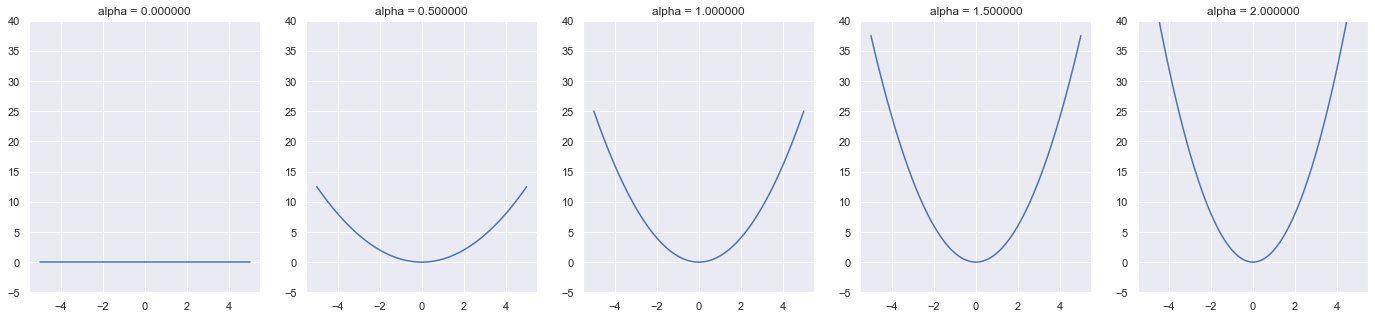

In [47]:
fig1, ax1 = plt.subplots(1,5, figsize=(24,5))

quad_x = np.linspace(-5,5,100)
quad_y = [i*(quad_x**2) for i in np.linspace(0,2,5)]

for i in range(5):
    ax1[i].set_ylim([-5, 40])
    ax1[i].plot(quad_x,quad_y[i])
    ax1[i].set_title("alpha = %f" %(np.linspace(0,2,5)[i]))

plt.show()

<h3 style="text-align: center; color:#028ad9;">Part 2: Data Preprocessing</h3>

<p style="margin:10px; font-size: 15px"> Now that our method has been derived, lets move on to applying it. First, we need to obtain the dataset, clean it, and decide which features will be used.</p> 

In [48]:
pd.options.display.max_columns = None
raw_data = pd.read_csv("./train.csv")
data = raw_data.copy()

In [49]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [50]:
data.dropna(axis=1,thresh=.8*data.shape[0],inplace=True)
data.dropna(axis=0,inplace=True)


for a,b,c,d in zip(data.columns[::4],data.columns[1::4],data.columns[2::4],data.columns[3::4]):
    print('{:<30}{:<30}{:<30}{:<}'.format(a,b,c,d))

    data.head()

Id                            MSSubClass                    MSZoning                      LotFrontage
LotArea                       Street                        LotShape                      LandContour
Utilities                     LotConfig                     LandSlope                     Neighborhood
Condition1                    Condition2                    BldgType                      HouseStyle
OverallQual                   OverallCond                   YearBuilt                     YearRemodAdd
RoofStyle                     RoofMatl                      Exterior1st                   Exterior2nd
MasVnrType                    MasVnrArea                    ExterQual                     ExterCond
Foundation                    BsmtQual                      BsmtCond                      BsmtExposure
BsmtFinType1                  BsmtFinSF1                    BsmtFinType2                  BsmtFinSF2
BsmtUnfSF                     TotalBsmtSF                   Heating                

In [51]:
data.dropna(axis=1,thresh=data.shape[0])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125


In [52]:
categorical_int_titles = list()
for title, n in zip(data.nunique().index,data.nunique()):
    if(n<20 and data.dtypes[title] != "object"):
        categorical_int_titles.append(title)

categorical_features = data.select_dtypes(include="object")
numeric_features = data.select_dtypes(exclude="object")
numeric_features = numeric_features.drop(columns = categorical_int_titles)

#data[categorical_int_titles].head()
categorical_features = categorical_features.reset_index(drop=True)
categorical_int_features = data[categorical_int_titles]
categorical_int_features.index = categorical_features.index

categorical_features = pd.concat([categorical_features,categorical_int_features],axis=1)

In [53]:
numeric_features.head()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SalePrice
0,1,65.0,8450,2003,2003,196.0,706,0,150,856,856,854,1710,2003.0,548,0,61,0,0,208500
1,2,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,0,1262,1976.0,460,298,0,0,0,181500
2,3,68.0,11250,2001,2002,162.0,486,0,434,920,920,866,1786,2001.0,608,0,42,0,0,223500
3,4,60.0,9550,1915,1970,0.0,216,0,540,756,961,756,1717,1998.0,642,0,35,272,0,140000
4,5,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,1053,2198,2000.0,836,192,84,0,0,250000


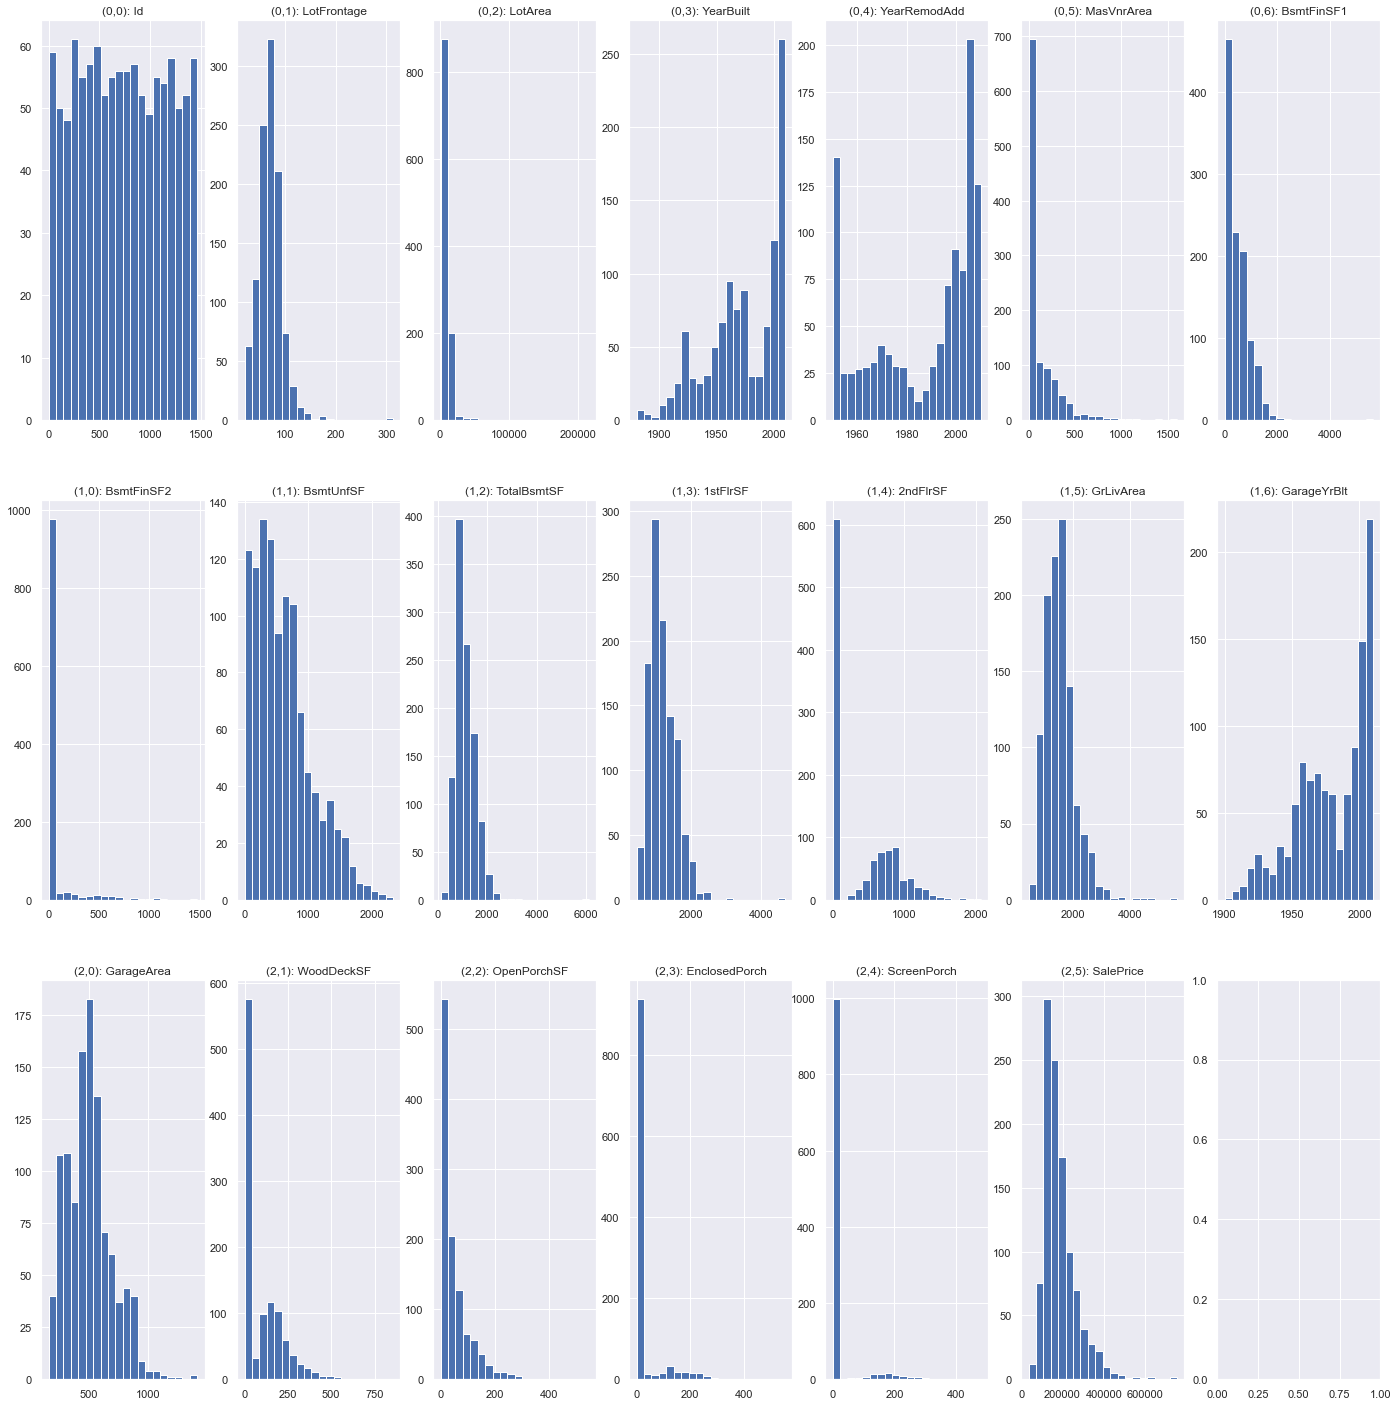

In [54]:
plots_per_line = int(len(numeric_features.columns)/3)+1
fig, ax2 = plt.subplots(3, plots_per_line, figsize=(24,4*int(len(numeric_features.columns)/3)+1))

for i,header in enumerate(numeric_features.columns):
    counts, bins = np.histogram(numeric_features[header][np.isfinite(numeric_features[header])],bins=20)
    ax2[int(i/plots_per_line)][i%plots_per_line].set_title("(%i,%i): %s"%(int(i/plots_per_line),i%plots_per_line,header) )
    ax2[int(i/plots_per_line)][i%plots_per_line].hist(bins[:-1], bins, weights=counts)
    

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

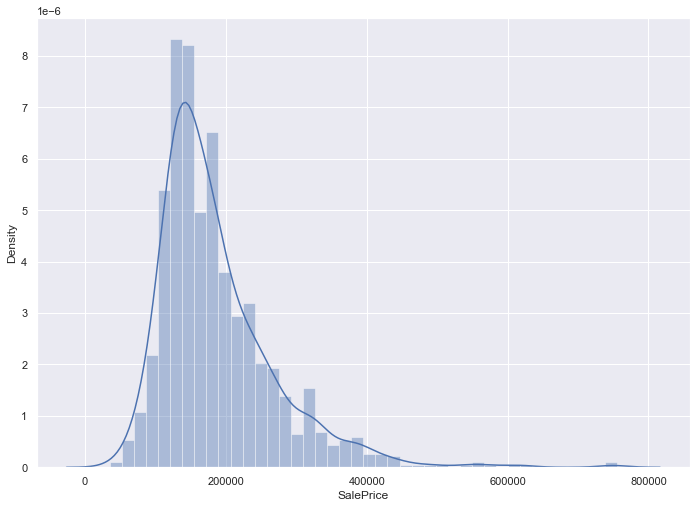

In [55]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot( data["SalePrice"] )

In [56]:
numeric_features = numeric_features.drop(columns=["BsmtFinSF2","Id"])

In [57]:
numeric_features.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SalePrice
0,65.0,8450,2003,2003,196.0,706,150,856,856,854,1710,2003.0,548,0,61,0,0,208500
1,80.0,9600,1976,1976,0.0,978,284,1262,1262,0,1262,1976.0,460,298,0,0,0,181500
2,68.0,11250,2001,2002,162.0,486,434,920,920,866,1786,2001.0,608,0,42,0,0,223500
3,60.0,9550,1915,1970,0.0,216,540,756,961,756,1717,1998.0,642,0,35,272,0,140000
4,84.0,14260,2000,2000,350.0,655,490,1145,1145,1053,2198,2000.0,836,192,84,0,0,250000


In [58]:
numeric_correlations = list()
for name in numeric_features.columns:
    numeric_correlations.append( [name, numeric_features[name].corr(numeric_features["SalePrice"]) ] )
    
numeric_correlations_df = pd.DataFrame(numeric_correlations)
valid_numeric = numeric_features[numeric_correlations_df[numeric_correlations_df[1] >= .4][0]]

In [59]:
categorical_features.dropna(axis=1,thresh=.8*categorical_features.shape[0], inplace=True)
categorical_features.dropna(axis=0,inplace=True)

In [60]:
binned_label_clsn, binned_label_intervals = pd.factorize(pd.qcut(numeric_features["SalePrice"],q=4))

results = {"label":list(),"X2":list()}

for cname in categorical_features.columns:
    stat, pval, dof, expected_freq = chi2_contingency(pd.crosstab(binned_label_clsn, categorical_features[cname]))
    results["label"].append(cname)
    results["X2"].append(pval)

chi2_result = pd.DataFrame(data = results)
chi2_result.sort_values(by = ['X2'], ascending = True, ignore_index = True, inplace = True)
valid_categorical = categorical_features[chi2_result["label"][0:5]]

In [61]:
def expand_categorical(df, columns):
    df_dummies = list()
    
    for col in columns:
        df_dummies.append(pd.get_dummies(df[col], prefix_sep = ':', prefix = col))
        
    additions = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, additions], axis = 1)
    df.drop(columns=columns,inplace=True)
    
    return df

In [62]:
y_train_mean = data["SalePrice"].mean()
y_train_std = data["SalePrice"].std()

y_train = (data["SalePrice"] - data["SalePrice"].mean())/data["SalePrice"].std()

valid_numeric.drop(columns="SalePrice",inplace=True)
valid_numeric.reset_index(inplace=True,drop=True)
valid_categorical.reset_index(inplace=True,drop=True)
valid_numeric.index = valid_categorical.index
X_train = pd.concat([valid_numeric,valid_categorical],axis=1)
valid_features = X_train.columns
X_train = expand_categorical(X_train,valid_categorical.columns)

X_train_mean = X_train.mean()
X_train_std = X_train.std()

X_train[valid_numeric.columns]= (X_train[valid_numeric.columns]-X_train[valid_numeric.columns].mean())/X_train[valid_numeric.columns].std()

In [63]:
valid_features

Index(['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'GarageYrBlt', 'GarageArea', 'OverallQual', 'Neighborhood',
       'GarageCars', 'BsmtQual', 'ExterQual'],
      dtype='object')

In [64]:
X_train.head()

,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,GarageArea,OverallQual:2,OverallQual:3,OverallQual:4,OverallQual:5,OverallQual:6,OverallQual:7,OverallQual:8,OverallQual:9,OverallQual:10,Neighborhood:Blmngtn,Neighborhood:Blueste,Neighborhood:BrDale,Neighborhood:BrkSide,Neighborhood:ClearCr,Neighborhood:CollgCr,Neighborhood:Crawfor,Neighborhood:Edwards,Neighborhood:Gilbert,Neighborhood:IDOTRR,Neighborhood:MeadowV,Neighborhood:Mitchel,Neighborhood:NAmes,Neighborhood:NPkVill,Neighborhood:NWAmes,Neighborhood:NoRidge,Neighborhood:NridgHt,Neighborhood:OldTown,Neighborhood:SWISU,Neighborhood:Sawyer,Neighborhood:SawyerW,Neighborhood:Somerst,Neighborhood:StoneBr,Neighborhood:Timber,Neighborhood:Veenker,GarageCars:1,GarageCars:2,GarageCars:3,GarageCars:4,BsmtQual:Ex,BsmtQual:Fa,BsmtQual:Gd,BsmtQual:TA,ExterQual:Ex,ExterQual:Fa,ExterQual:Gd,ExterQual:TA
0,0.980699,0.816219,0.451805,-0.585693,-0.819779,0.332569,0.942152,0.230101,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
1,0.115030,-0.473748,-0.576163,0.390617,0.227483,-0.518941,-0.098935,-0.227610,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
2,0.916575,0.768443,0.273484,-0.431792,-0.654693,0.477022,0.865034,0.542176,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
3,-1.840741,-0.760407,-0.576163,-0.826164,-0.548935,0.345874,0.749358,0.719019,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
4,0.884513,0.672889,1.259493,0.109267,-0.074314,1.260107,0.826476,1.728062,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [65]:
X = X_train.to_numpy()
y = np.reshape( y_train.to_numpy(),(-1,1))

theta = np.linalg.inv(X.T@X)@X.T@y

In [89]:

# TEST 

test_row = X_train.iloc[89]
test_lab = y_train.iloc[89]


print ( "Training set average estimation error:" + str( ( ((X_train@theta) * y_train_std + y_train_mean) - ((y_train*y_train_std)+y_train_mean)).abs().mean().iloc[0]))







AttributeError: 'str' object has no attribute 'abs'

In [86]:
naive_dataset = data.copy()

naive_dataset.dropna(inplace=True)
naive_Y_train = naive_dataset["SalePrice"]
naive_dataset.drop(columns="SalePrice",inplace=True)

dummies = pd.get_dummies(naive_dataset)
naive_dataset = pd.concat([naive_dataset, dummies], axis="columns")
naive_dataset.drop(columns=dummies.columns, inplace=True)

naive_X_train = dummies.to_numpy()
naive_Y_train = naive_Y_train.to_numpy()
naive_Y_train = np.reshape( naive_Y_train,(-1,1))

naive_theta = (naive_X_train.T@naive_X_train)@naive_X_train.T@naive_Y_train

print ( "Naive testing error: " + str(( (naive_X_train@naive_theta) - naive_Y_train).mean() ) )


Naive testing error: 5.566337138462752e+27


In [ ]:

#import pandas
import pandas as pd
 
# read csv
df = pd.read_csv('salary.csv')
 
# get the dummies and store it in a variable
dummies = pd.get_dummies(df.Education)
 
# Concatenate the dummies to original dataframe
merged = pd.concat([df, dummies], axis='columns')
 
# drop the values
merged.drop(['Education', 'Under-Graduate'], axis='columns')
 
# print the dataframe
print(merged)

In [ ]:
train_data = pd.read_csv("./train.csv")
X_test = train_data[valid_features]
y_test = train_data["SalePrice"]

In [ ]:
pd.concat([valid_features,["SalePrice"]])

In [ ]:
def predict(F,T):
    mean = F.mean()
    std = F.std()
    F = (F-mean)/std
    unscaled_results = F@T
    return (unscaled_results+mean)*std
     

In [ ]:
X_test = expand_categorical(X_test, valid_categorical.columns)


predict(X_test,theta)

In [ ]:
X_test.dropna().isna().sum()

In [ ]:
X_test